В этой работе используются большие переменные и функции, выведенные в отдельный модуль.

Исходный код можно посмотреть на github: https://github.com/Hell-Writer/HW-Probabilibi


In [1]:
import warnings
from collections import Counter, defaultdict
from functools import reduce
from itertools import combinations_with_replacement, permutations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.bootstrap import IIDBootstrap
from scipy import stats as sts

from custom_module import (evf1, means_dif, mlf1, od_ratio, t_bootstrap,
                           t_bootstrap_2_pvalue)
from settings import ARABIC_NAMES, EVF1_INVERSE_VALUES, RUSSIAN_VOWELS

In [2]:
warnings.filterwarnings("ignore")
swag = 42069

# Задание 1

1.а

Вероятность  получить уже знакомого таксиста в i-ый вызов $\frac{i-1}{n}$, то есть вероятность получить другого таксита $1 - \frac{i-1}{n}$. Значит функция правдоподибия: $$L(n) = \frac{9}{n} \cdot \prod_{j=1}^{9} (1 - \frac{j}{n})$$

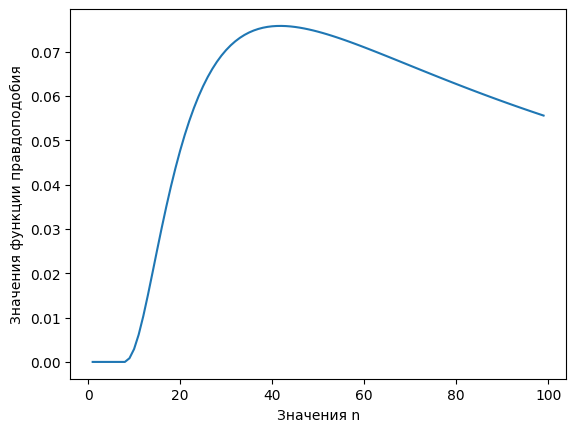

In [5]:
x = [i for i in range(1,100)]
y = [mlf1(i,9) for i in x]
plt.xlabel('Значения n')
plt.ylabel('Значения функции правдоподобия')
plt.plot(x, y);

In [6]:
print(max(sorted(list(zip(y,x)))))

(0.07578610920557893, 42)


Оценка $n_{ML} = 42$

1.b

$$P(повторный\; приезд \;=\; j-ый \;приезд) = \frac{j-1}{n} \cdot \prod_{i=1}^{j-1} (1 - \frac{i}{n})$$
Тогда матожидание: $$E(j) = \sum_{j=1}^{\infty} [j\cdot \frac{j-1}{n} \cdot \prod_{i=1}^{j-1} (1 - \frac{i}{n})]$$

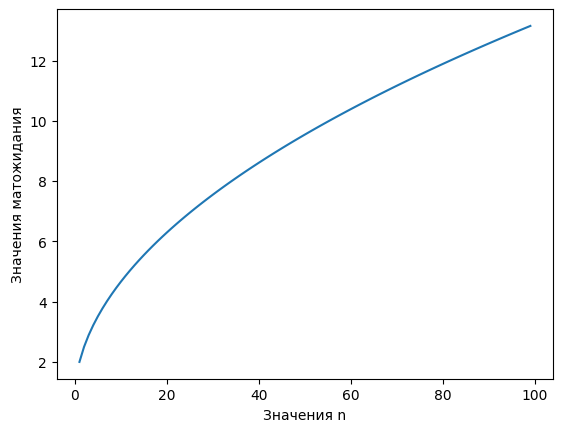

In [7]:
x = [i for i in range(1,100)]
y = list(map(evf1, x))
plt.xlabel('Значения n')
plt.ylabel('Значения матожидания')
plt.plot(x, y);

Оценка n методом моментов:

$$n = g^{(-1)}(\bar j)$$

In [8]:
j = 0
n = 2
while j<9:
    j = evf1(n)
    n+=1
print(n)

46


Оценка $n_{MM} = 46$

1.c

In [9]:
obs = 10000
xn = 600
avg_list = []
MM = []
ML = []
x = [i for i in range(5, xn)]
for i in range(obs):
    taxi_drivers = defaultdict(int)
    cnt = 0
    while True:
        cnt+=1
        taxi_driver = np.random.choice(ARABIC_NAMES)
        if taxi_drivers[taxi_driver] > 0:
            break
        else:
            taxi_drivers[taxi_driver] +=1
    avg_list.append(cnt)
    y = [mlf1(item, cnt) for item in range(2, xn)]
    ML.append(max(zip(y,x))[1])
    MM.append(EVF1_INVERSE_VALUES[cnt-1])
sum(avg_list)/obs

13.2205

In [10]:
df = pd.DataFrame(np.array([MM, ML]).T, columns=['MM', 'ML'])
df = df[df['MM']<400]
df.head()

,MM,ML
0,192,186
1,150,150
2,68,77
3,55,65
4,113,118


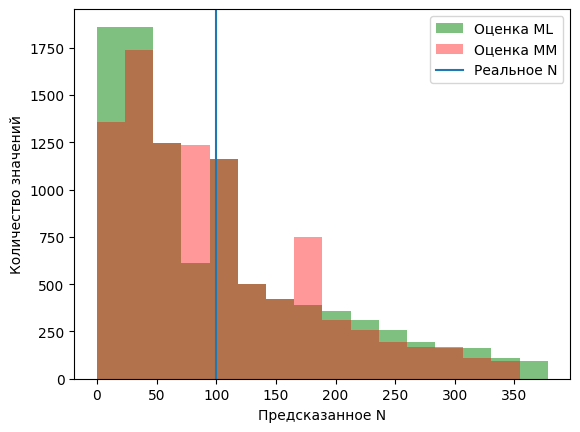

In [11]:
_, bins, _ = plt.hist(df['MM'], bins=16, alpha=0.5, color='g', label='Оценка ML')
_ = plt.hist(df['ML'], bins=bins, alpha=0.4, color='r', label='Оценка MM')
plt.axvline(100, label='Реальное N')
plt.legend()
plt.xlabel('Предсказанное N')
plt.ylabel('Количество значений');

In [12]:
msemm = sum([(100-item)**2 for item in MM])/len(MM)
mseml = sum([(100-item)**2 for item in ML])/len(ML)
varmm = np.array(MM).var()
varml = np.array(ML).var()
devmm = np.array(MM).mean() - 100
devml = np.array(ML).mean() - 100
df = pd.DataFrame([[msemm,varmm,devmm],[mseml,varml,devml]], index=['MM', 'ML'], columns=['MSE', 'Дисперсия', 'Смещение'])
df

,MSE,Дисперсия,Смещение
MM,12386.2943,12298.506770,9.3695
ML,9444.9545,9320.710038,11.1465


# Задание 3

3.а

In [13]:
n_obs = 10000
true_guess = {'Normal': 0, 'Naive bootstrap': 0, 'Tbootstrap': 0}
for i in range(n_obs):
    vyborka = np.random.exponential(1, 20)
    mu = vyborka.mean()
    s = vyborka.std()
    z_obs = [vyborka.mean()-1.96*vyborka.std()/np.sqrt(20), vyborka.mean()+1.96*vyborka.std()/np.sqrt(20)]
    nb_obs = sts.bootstrap((vyborka,), np.mean, confidence_level=0.95, method='percentile')
    tb_obs = t_bootstrap(vyborka, 0.05, 100)
    if z_obs[0]<1 and z_obs[1]>1:
        true_guess['Normal']+=1
    if nb_obs.confidence_interval[0]<1 and nb_obs.confidence_interval[1]>1:
        true_guess['Naive bootstrap']+=1
    if tb_obs[0]<1 and tb_obs[1]>1:
        true_guess['Tbootstrap']+=1
print(true_guess)

{'Normal': 8928, 'Naive bootstrap': 8992, 'Tbootstrap': 8804}


In [14]:
print('Вероятности накрытия матожидания доверительным интервалом для:')
print(f"Нормального интервала {true_guess['Normal']/n_obs}")
print(f"Наивного бутстрепа {true_guess['Naive bootstrap']/n_obs}")
print(f"t-бутстрепа {true_guess['Tbootstrap']/n_obs}")

Вероятности накрытия матожидания доверительным интервалом для:
Нормального интервала 0.8928
Наивного бутстрепа 0.8992
t-бутстрепа 0.8804


Как видно, вероятность оказалась равна примерно 90%, что меньше, чем 95%. Видимо так происходит из-за не нормальности выборки. В экспоненциальном распределении где-то две трети наблюдений будут меньше матожидания и лишь треть - больше.

3.б

In [15]:
n_obs = 10000
true_guess = {'Normal': 0, 'Naive bootstrap': 0, 'Tbootstrap': 0}
for i in range(n_obs):
    vyborka = np.random.standard_t(3, 20)
    mu = vyborka.mean()
    s = vyborka.std()
    z_obs = [vyborka.mean()-1.96*vyborka.std()/np.sqrt(20), vyborka.mean()+1.96*vyborka.std()/np.sqrt(20)]
    nb_obs = sts.bootstrap((vyborka,), np.mean, confidence_level=0.95, method='percentile')
    tb_obs = t_bootstrap(vyborka, 0.05, 100)
    if z_obs[0]<0 and z_obs[1]>0:
        true_guess['Normal']+=1
    if nb_obs.confidence_interval[0]<0 and nb_obs.confidence_interval[1]>0:
        true_guess['Naive bootstrap']+=1
    if tb_obs[0]<0 and tb_obs[1]>0:
        true_guess['Tbootstrap']+=1
print(true_guess)

{'Normal': 9370, 'Naive bootstrap': 9203, 'Tbootstrap': 9459}


In [16]:
print('Вероятности накрытия матожидания доверительным интервалом для:')
print(f"Нормального интервала {true_guess['Normal']/n_obs}")
print(f"Наивного бутстрепа {true_guess['Naive bootstrap']/n_obs}")
print(f"t-бутстрепа {true_guess['Tbootstrap']/n_obs}")

Вероятности накрытия матожидания доверительным интервалом для:
Нормального интервала 0.937
Наивного бутстрепа 0.9203
t-бутстрепа 0.9459


В этот раз вероятности получились выше, потому что t распределение симметрично

3.в

На выборке из асимметричного распределения лучше всего показал себя наивный бутстреп, а из симметричного - бутстреп t-статистики

# Задание 4

In [17]:
df = pd.read_csv('exam.csv')

In [18]:
df = df[['Last name', 'res']]
df.head()

,Last name,res
0,Репенкова,16
1,Ролдугина,0
2,Сафина,19
3,Сидоров,26
4,Солоухин,21


In [19]:
v_sample = []
c_sample = []
for item in df['Last name']:
    if list(item)[0] in RUSSIAN_VOWELS:
        v_sample.append(list(df.loc[df['Last name'] == item, 'res'])[0])
    else:
        c_sample.append(list(df.loc[df['Last name'] == item, 'res'])[0])

4.a

In [20]:
print(f'p-значение: {round(sts.ttest_ind(v_sample, c_sample, equal_var=False)[1],4)}')
print(f'Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается ')

p-значение: 0.4697
Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается 


4.б

In [21]:
for i in range(400,500):
    bootstat = sts.bootstrap((v_sample, c_sample), means_dif, confidence_level=1 - i/1000, method='percentile')
    p_val = i/1000
    if bootstat.confidence_interval[0]>0 or bootstat.confidence_interval[1]<0:
        break

print(f"p-значение: {p_val}")
print(f'Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается ')

p-значение: 0.453
Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается 


4.в

In [22]:
print(f"p-значение: {round(t_bootstrap_2_pvalue(c_sample, v_sample, 10000), 4)}")
print(f'Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается ')

p-значение: 0.4648
Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается 


4.г

In [23]:
print(f"p-значение: {round(sts.permutation_test((c_sample, v_sample), statistic=means_dif, vectorized=True).pvalue, 4)}")
print(f'Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается')

p-значение: 0.4648
Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается


# Задание 5

In [24]:
df5 = df[df['res']>0]
mid = np.median(df5['res'])
mid

18.0

In [25]:
gc = []
lc = []
gv = []
lv = []
for item in df['Last name']:
    if list(item)[0] in RUSSIAN_VOWELS:
        if list(df.loc[df['Last name'] == item, 'res'])[0] > mid:
            gv.append(list(df.loc[df['Last name'] == item, 'res'])[0])
        else:
            lv.append(list(df.loc[df['Last name'] == item, 'res'])[0])
    else:
        c_sample.append(list(df.loc[df['Last name'] == item, 'res'])[0])
        if list(df.loc[df['Last name'] == item, 'res'])[0] > mid:
            gc.append(list(df.loc[df['Last name'] == item, 'res'])[0])
        else:
            lc.append(list(df.loc[df['Last name'] == item, 'res'])[0])

In [26]:
df_chi2 = pd.DataFrame([[len(gc), len(lc)], [len(gv), len(lv)]], columns=['greater', 'less'], index=['consonant', 'vowel'])
df_chi2

,greater,less
consonant,123,160
vowel,20,29


5.а

In [27]:
odds_ratio = sts.contingency.odds_ratio([[len(gc), len(lc)], [len(gv), len(lv)]])
for i in range(100):
    p_val = i/100
    oddstat = odds_ratio.confidence_interval(1-p_val)
    if oddstat[0]>1 or oddstat[1]<1:
        break
print(f'Доверительный интервал для отношения шансов: {[_ for _ in odds_ratio.confidence_interval(0.95)]}')
print(f"p-значение: {p_val}")
print(f'Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается')

Доверительный интервал для отношения шансов: [0.5776855153704006, 2.185183561663949]
p-значение: 0.86
Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается


5.б

In [28]:
pirs = sts.chi2_contingency([[len(gc), len(lc)], [len(gv), len(lv)]])
pirs
print(f'Доверительный интервал для отношения вероятностей: {[odds_ratio.statistic/sts.chi2(df=1).ppf(0.975), odds_ratio.statistic/sts.chi2(df=1).ppf(0.025)]}')
print(f"p-значение: {pirs.pvalue}")
print(f'Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается')

Доверительный интервал для отношения вероятностей: [0.22180539206400857, 1134.670692697771]
p-значение: 0.8499518448835025
Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается


5.в

In [29]:
for i in range(0, 100):
    bootstat = sts.bootstrap(([0 for i in range(len(gc))] + [1 for i in range(len(lc))] + [2 for i in range(len(gv))] + [3 for i in range(len(lv))],), od_ratio, confidence_level=1 - i/100, method='percentile')
    p_val = i/100
    if bootstat.confidence_interval[0]>1 or bootstat.confidence_interval[1]<1:
        break
ci = sts.bootstrap(
    ([0 for i in range(len(gc))] + [1 for i in range(len(lc))] + [2 for i in range(len(gv))] + [3 for i in range(len(lv))],),
    od_ratio,
    confidence_level=0.95,
    method='percentile'
    ).confidence_interval
print(f"Доверительный интервал для отношения шансов: {[ci[0], ci[1]]}")
print(f"p-значение: {p_val}")
print(f'Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается ')

Доверительный интервал для отношения шансов: [0.6053375796178344, 2.1485420468252228]
p-значение: 0.73
Вывод: На уровне значимости в 5% нулевая гипотеза не отвергается 


# Задание 6

6.a

$$E(y_i) = \beta F_i =\frac{1}{n} \sum_{i=1}^{n} y_i$$
$$E(Y) = \beta \sum_{i=1}^{n} F_i = \sum_{i=1}^{n} y_i$$
$$\beta = \frac {\sum_{i=1}^{n} y_i}{\sum_{i=1}^{n} F_i}$$

In [30]:
df5['length'] = df5['Last name'].apply(len)

In [31]:
df6 = df5[['res', 'length']]

In [32]:
beta = sum(df6['res'])/sum(df6['length'])
print(f'β: {beta}')

β: 2.310996563573883


In [33]:
df6['length'] = df6['length'].apply(lambda x: x*beta)

In [34]:
print(f"Коэффициент выборочной корреляции: {np.corrcoef(df6['res'], df6['length'])[0][1]}")

Коэффициент выборочной корреляции: 0.033327203424463867


# Задание 7

<img src="https://i.ibb.co/NjfmcG8/photo1686063649.jpg" alt="photo1686063649" border="0" width="400" height="900">

<img src="https://i.ibb.co/BTxJCQL/photo1686063649-1.jpg" alt="photo1686063649-1" border="0" width="400" height="900">

<img src="https://i.ibb.co/KNdZxGs/photo1686063649-2.jpg" alt="photo1686063649-2" border="0" width="400" height="900">

P.S. Задачка для проверяющего:
По трём наблюдениям построить 90% интервал для матожидания скорости интернета в моём доме

# Задание 8

3Blue1Brown - очень классный Youtube канал, смотрю его уже лет пять. Там много всего, в том числе теория вероятностей

https://www.youtube.com/@3blue1brown/videos

Primer - тоже канал на Youtube. Все видео посвящены всяким визуализациям статистики.

https://www.youtube.com/@PrimerBlobs

Конкретно вот это видео помогло мне понять ошибки первого и второго рода и мощность критерия: https://www.youtube.com/watch?v=XTcP4oo4JI4